In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from datetime import datetime

In [2]:
def animate_density_evolution(dimensions: tuple[int, int], filename: str, interval: int = 100, repeat: bool = False) -> FuncAnimation:
    # Read the CSV file
    df = pd.read_csv(filename, header=None)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(np.zeros(dimensions).T, cmap='viridis', origin='lower', animated=True)
    plt.colorbar(img)
    
    ax.set_title('Density Evolution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    def init():
        img.set_array(np.zeros(dimensions).T)
        return [img]
    
    def update(frame):
        # Reshape the flattened data back to 2D and transpose
        current_density = df.iloc[frame].values.reshape(dimensions, order='F').T
        img.set_array(current_density)
        img.set_clim(vmin=df.values.min(), vmax=df.values.max())
        return [img]
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(df),
                        init_func=init, blit=True,
                        interval=interval, repeat=repeat)
    
    return anim

In [3]:
def display_density_heatmap(density: NDArray[np.float64], title: str = 'Density Distribution'):
    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(density.T, cmap='viridis', origin='lower')
    plt.colorbar(heatmap, label='Density')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

In [4]:
def visualize_velocity_field(velocity_field: NDArray[np.float64], title: str = 'Velocity Field') -> None:
    """
    Visualize a 2D velocity field using quiver plot.
    
    Args:
        velocity_field: Array of shape (2, height, width) containing x and y components of velocity
        title: Title of the plot
    """
    # Get dimensions of the field
    _, width, height = velocity_field.shape
    
    # Create coordinate meshgrid
    x, y = np.meshgrid(np.arange(width), np.arange(height), indexing='ij')
    
    # Extract x and y components of velocity
    u = velocity_field[0]  # x-component
    v = velocity_field[1]  # y-component
    
    # Calculate velocity magnitude for color mapping
    magnitude = np.sqrt(u**2 + v**2)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot velocity vectors with magnitude-based coloring
    plt.quiver(x, y, u, v, magnitude, 
               cmap='viridis',
               scale=30,
               width=0.005)
    
    plt.colorbar(label='Velocity magnitude')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [5]:
def get_ring_initial_distribution(sites: tuple[int, int], 
                              cylinder_radius_outer: float,
                              cylinder_radius_inner: float,
                              background_density: float = 0.1,
                              ring_density: float = 0.4) -> NDArray[np.float64]:
    """
    Create a ring-shaped initial distribution.
    
    Args:
        sites: Tuple of (height, width) for the grid
        cylinder_radius_outer: Outer radius of the ring
        cylinder_radius_inner: Inner radius of the ring
        background_density: Density value outside the ring
        ring_density: Density value in the ring region
        
    Returns:
        density: Initial density distribution with a ring pattern
    """
    # Initialize density array with background value
    density = np.full(sites, background_density)
    
    # Create coordinate grid
    x = np.arange(sites[0])
    y = np.arange(sites[1])
    X, Y = np.meshgrid(x, y)
    
    # Calculate center points
    center_x = sites[0] / 2
    center_y = sites[1] / 2
    
    # Create ring mask
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    ring_mask = ((distance_from_center < cylinder_radius_outer) & 
                 (distance_from_center > cylinder_radius_inner)).T
    
    # Set ring density
    density[ring_mask] = ring_density
    
    return density

def get_shear_velocity_field(sites: tuple[int, int], u_magnitude: float = 0.2, v_magnitude: float = 0.1) -> NDArray[np.float64]:
    """
    Create a shear velocity field with opposite horizontal velocities in upper and lower halves.
    
    Args:
        sites: Tuple of (width, height) for the grid
        u_magnitude: Magnitude of horizontal velocity
        v_magnitude: Magnitude of vertical velocity
        
    Returns:
        velocity_field: Array of shape (2, height, width) containing the velocity components
    """
    
    # Initialize velocity components with proper orientation
    u = np.full(sites, u_magnitude)
    v = np.full(sites, v_magnitude)
    
    
    u[:, int(sites[1] / 2):] = -u_magnitude
    
    # Stack into velocity field (u=horizontal velocity, v=vertical velocity)
    velocity_field = np.stack([u, v])
    
    return velocity_field

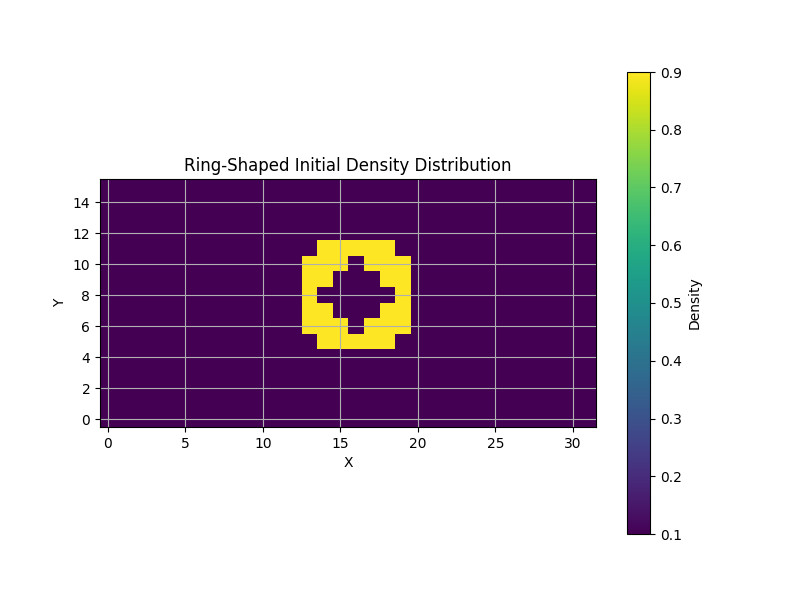

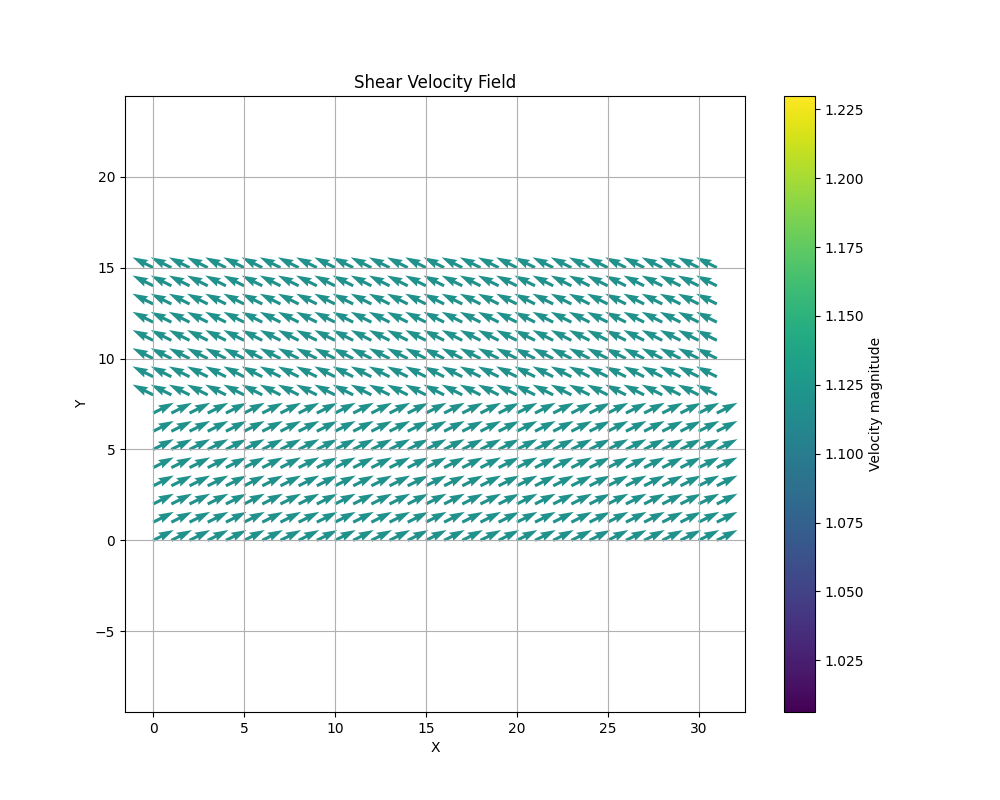

In [26]:
# Create new sites configuration
sites_ring = (32, 16)
links = [[0,0], [-1, 0], [1,0], [0, -1], [0, 1], [-1, -1], [-1, 1], [1, -1], [1, 1]]
weights = [4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]
speed_of_sound = 1/np.sqrt(3)
# Define ring parameters
cylinder_radius_outer = 4
cylinder_radius_inner = 2
background_density = 0.1
ring_density = 0.9

# Create ring-shaped initial distribution
#
initial_dist_ring = get_ring_initial_distribution(sites_ring, cylinder_radius_outer, cylinder_radius_inner, background_density, ring_density)

# Visualize ring-shaped initial density
display_density_heatmap(initial_dist_ring, title='Ring-Shaped Initial Density Distribution')

# Create shear velocity field
shear_velocity_field = get_shear_velocity_field(sites_ring, u_magnitude=0.2, v_magnitude=0.1)

# Visualize shear velocity field
visualize_velocity_field(shear_velocity_field*5, title='Shear Velocity Field')

zero_velocity_field = np.stack([np.zeros(sites_ring), np.zeros(sites_ring)])
#visualize_velocity_field(zero_velocity_field, title='Zero Velocity Field')

# Update configuration for simulation
config_ring = [(50, shear_velocity_field, links, weights, speed_of_sound)]

In [27]:
import importlib
import qlbmlib
importlib.reload(qlbmlib)

<module 'qlbmlib' from 'd:\\Data\\Codes\\Quantum\\Research\\qlbmlib.py'>

In [28]:
# Create unique filename with timestamp for ring simulation
timestamp_ring = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_ring = f"experiments/generic/experiment_{timestamp_ring}.csv"

# Run simulation for ring configuration
density_ring = qlbmlib.simulate_flow(initial_dist_ring, config_ring, filename_ring, enable_quantum_macros=True)

print(f"Ring simulation complete. Results saved to {filename_ring}")

Circuit configuration: will run iterations 0-50/50 with this configuration
Iteration 1 running...
Iteration 1/50:
  Compilation: 1.960 seconds
  Execution: 0.812 seconds
  Total: 2.772 seconds
Iteration 2 running...
Iteration 2/50:
  Compilation: 2.100 seconds
  Execution: 0.913 seconds
  Total: 3.014 seconds
Iteration 3 running...
Iteration 3/50:
  Compilation: 2.096 seconds
  Execution: 0.826 seconds
  Total: 2.923 seconds
Iteration 4 running...
Iteration 4/50:
  Compilation: 2.019 seconds
  Execution: 0.807 seconds
  Total: 2.826 seconds
Iteration 5 running...
Iteration 5/50:
  Compilation: 2.002 seconds
  Execution: 0.804 seconds
  Total: 2.806 seconds
Iteration 6 running...
Iteration 6/50:
  Compilation: 2.016 seconds
  Execution: 0.805 seconds
  Total: 2.822 seconds
Iteration 7 running...
Iteration 7/50:
  Compilation: 1.990 seconds
  Execution: 0.807 seconds
  Total: 2.797 seconds
Iteration 8 running...
Iteration 8/50:
  Compilation: 2.002 seconds
  Execution: 0.818 seconds
  To

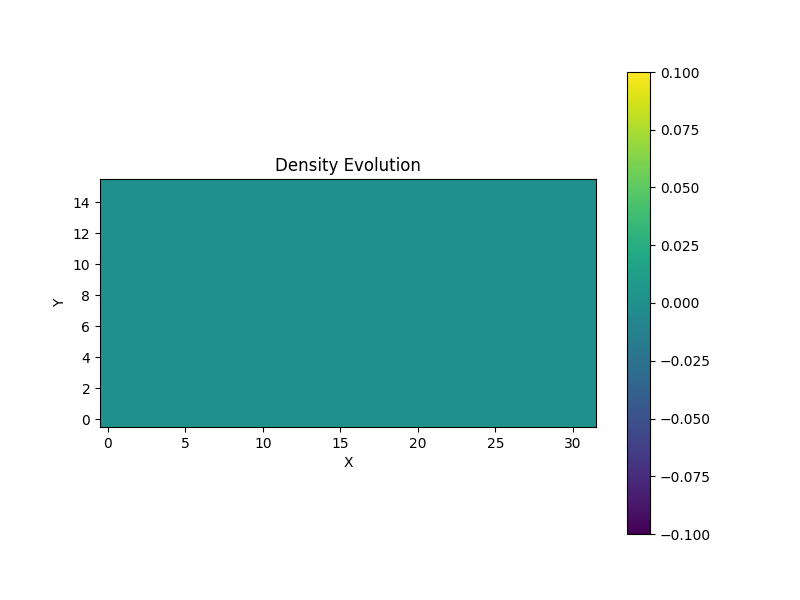

In [29]:
%matplotlib widget

anim = animate_density_evolution(sites_ring, filename_ring, interval=100, repeat=False)
plt.show()

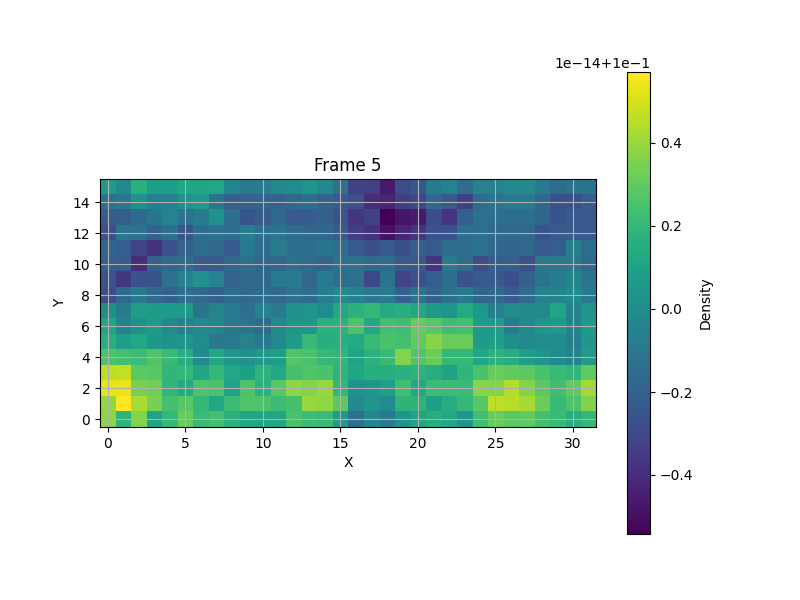

ValueError: Frame 15 not found. File only has 11 frames.

In [20]:
def display_frame(dimensions: tuple[int, int], filename: str, frame: int, title: str = None) -> None:
    """Display a specific frame from the simulation data file.
    
    Args:
        dimensions: Tuple of (height, width) for the grid
        filename: Path to the CSV file containing simulation data
        frame: Frame number to display (0-based index)
        title: Optional title for the plot
    """
    # Read the CSV file
    df = pd.read_csv(filename, header=None)
    
    if frame >= len(df):
        raise ValueError(f"Frame {frame} not found. File only has {len(df)} frames.")
    
    # Get the frame data and reshape it
    frame_data = df.iloc[frame].values.reshape(dimensions, order='F')
    
    # Create the heatmap
    display_density_heatmap(frame_data, title=title or f'Density Distribution at Frame {frame}')

# Example usage - display frame 5
frames_to_show = [5, 15, 35, 50]  # Show initial, middle, and final frames
for frame in frames_to_show:
    display_frame(sites_ring, filename_ring, frame, f'Frame {frame}')


In [ ]:
def save_iteration_heatmaps(dimensions: tuple[int, int], 
                          filename: str, 
                          iterations: list[int],
                          output_dir: str = None,
                          dpi: int = 300) -> None:
    """Save heatmap plots for specified iterations from a simulation CSV file.
    
    Args:
        dimensions: Tuple of (height, width) for the grid
        filename: Path to the CSV file containing simulation data
        iterations: List of iteration numbers to save (0-based indexing)
        output_dir: Directory to save the plots (defaults to 'experiments/heatmaps/{timestamp}')
        dpi: Resolution of the saved images
    """
    # Read the CSV file
    df = pd.read_csv(filename, header=None)
    
    # Create output directory with timestamp if not specified
    if output_dir is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = f"experiments/heatmaps/sim_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Get base filename without path and extension
    base_name = os.path.splitext(os.path.basename(filename))[0]
    
    # Process each requested iteration
    for iteration in iterations:
        if iteration >= len(df):
            print(f"Warning: Iteration {iteration} not found. File only has {len(df)} frames.")
            continue
            
        # Get the frame data and reshape it
        frame_data = df.iloc[iteration].values.reshape(dimensions, order='F')
        
        # Create the plot
        plt.figure(figsize=(8, 6))
        heatmap = plt.imshow(frame_data.T, cmap='viridis', origin='lower')
        plt.colorbar(heatmap, label='Density')
        plt.title(f'Density Distribution at Iteration {iteration}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        
        # Save the plot
        output_file = os.path.join(output_dir, f"{base_name}_iter{iteration:04d}.png")
        plt.savefig(output_file, dpi=dpi, bbox_inches='tight')
        plt.close()
        
        print(f"Saved heatmap for iteration {iteration} to {output_file}")

# Example usage - save heatmaps for specific iterations
iterations_to_save = [0, 10, 20, 30, 40, 49]  # Start, intermediate steps, and end
filename_ring = f"experiments/generic/density_evolution_ring{timestamp_ring}.csv"
save_iteration_heatmaps(sites_ring, filename_ring, iterations_to_save)

NameError: name 'filename_ring' is not defined

In [ ]:
def compute_rmse_evolution(dimensions: tuple[int, int], file1: str, file2: str) -> tuple[list[float], list[float]]:
    """Compute RMSE between two simulation files at each iteration.
    
    Args:
        dimensions: Tuple of (height, width) for the grid
        file1: Path to the first CSV file containing simulation data
        file2: Path to the second CSV file containing simulation data
        
    Returns:
        Tuple containing (iteration_numbers, rmse_values)
    """
    # Read both CSV files
    df1 = pd.read_csv(file1, header=None)
    df2 = pd.read_csv(file2, header=None)
    
    # Verify files have same number of iterations
    if len(df1) != len(df2):
        raise ValueError(f"Files have different number of iterations: {len(df1)} vs {len(df2)}")
    
    # Initialize list to store RMSE values
    rmse_values = []
    iteration_numbers = list(range(len(df1)))
    
    # Compute RMSE for each iteration
    for i in range(len(df1)):
        # Get frame data and reshape
        frame1 = df1.iloc[i].values.reshape(dimensions, order='F')
        frame2 = df2.iloc[i].values.reshape(dimensions, order='F')
        
        # Compute difference and RMSE
        diff = frame1 - frame2
        rmse = np.sqrt(np.mean(diff**2))
        rmse_values.append(rmse)
    
    return iteration_numbers, rmse_values

5.5425625842204065
5.5425625842204065
4.897322019529035
4.89732201952897
4.61766767988573
4.617667679885602
4.451117101474174
4.4511171014739865
4.340063551009075
4.340063551008834
4.260211777473398
4.2602117774731045
4.198755686697943
4.198755686697601
4.148487469646471
4.148487469646078
4.105305402877197
4.1053054028767555
4.066875442188072
4.066875442187584
4.031863945564396
4.03186394556386
3.9994974375866184
3.9994974375860375
3.969313209366716
3.9693132093660894
3.9410198190025567
3.9410198190018852
3.914419929451253
3.914419929450536
3.889368088741757
3.889368088740996
3.865747911609027
3.8657479116082243
3.8434599335733566
3.84345993357251
3.8224152687361816
3.8224152687352935
3.802532373229626
3.8025323732286958
3.7837354314276612
3.783735431426688
3.765953559862389
3.765953559861373
3.749120400100917
3.749120400099859
3.733173879124156
3.7331738791230555
3.718056028438802
3.7180560284376587
3.70371281310173
3.7037128131005446
3.6900939525960177
3.6900939525947916
3.6771527303

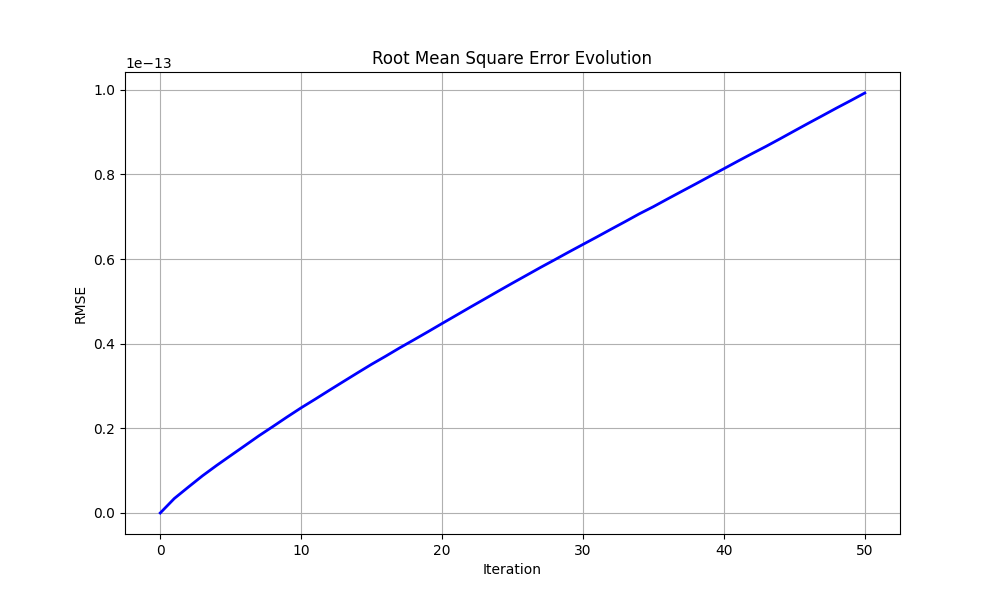

In [30]:
# Example usage - compare two simulation files and plot RMSE evolution
try:
    iterations, rmse = compute_rmse_evolution(
        dimensions=sites_ring,
        file1=filename_ring,
        file2="experiments/quantum_density_evolution.csv"
    )
    
    # Create the RMSE evolution plot
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, rmse, 'b-', linewidth=2)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Root Mean Square Error Evolution')
    
    # Add some statistics
    print(f"RMSE Statistics:")
    print(f"Mean RMSE: {np.mean(rmse):.6f}")
    print(f"Max RMSE: {np.max(rmse):.6f}")
    print(f"Min RMSE: {np.min(rmse):.6f}")
    
    plt.show()
    
except Exception as e:
    print(f"Error comparing files: {e}")